# Project 3 - Face Morphing
Romil Bhardwaj

Before running this notebook, please annotate your faces using annotate.py

In [2]:
import copy
import csv
import numpy as np
import skimage as sk
import skimage.io as skio
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.spatial.qhull import Delaunay
from skimage.color import rgb2gray
from skimage.draw import draw
from skimage.transform import rescale, resize
import os
import time

## Define functions

Frame morph time: 0.326127290725708
Frame morph time: 0.31116771697998047
Frame morph time: 0.28822803497314453
Frame morph time: 0.3151571750640869
Frame morph time: 0.3141591548919678
Frame morph time: 0.2952091693878174
Frame morph time: 0.34906506538391113
Frame morph time: 0.34707021713256836
Frame morph time: 0.3081943988800049
Frame morph time: 0.3171513080596924
Frame morph time: 0.307178258895874


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


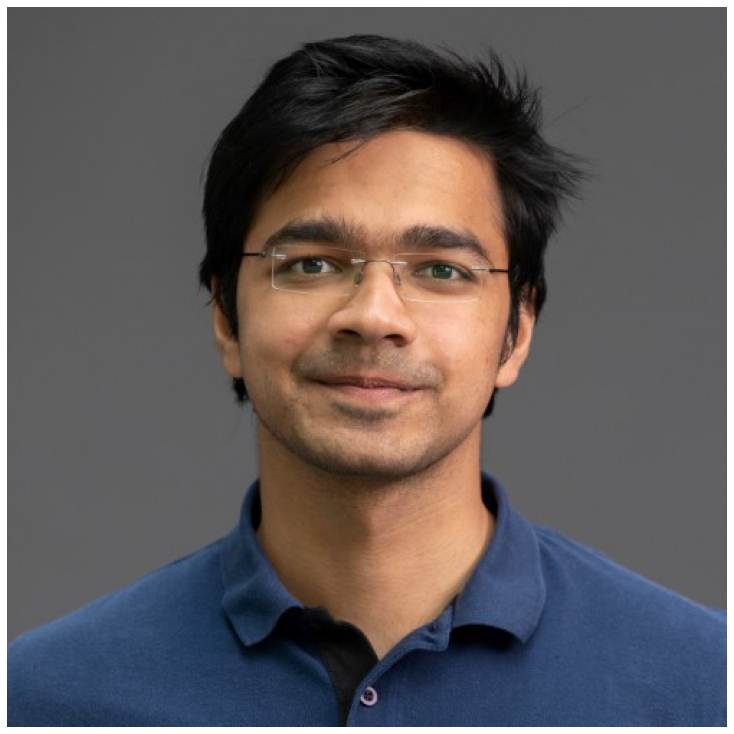

In [31]:
def get_affine_transform(tri1_pts, tri2_pts):
    m1 = np.array([tri1_pts[:,0], tri1_pts[:, 1], [1, 1, 1]])
    m2 = np.array([tri2_pts[:,0], tri2_pts[:, 1], [1, 1, 1]])
    return np.matmul(m2, np.linalg.inv(m1))

def masked_affine_tranform(im, mask, affine_transform):
    affine_0, affine_1, _ = np.matmul(np.linalg.inv(affine_transform), mask).astype(np.int)
    mask_0, mask_1, _ = mask.astype(np.int)
    result = np.zeros_like(im)
    result[mask_1, mask_0] = im[affine_1, affine_0]
    return result

def read_keypoints(csv_path):
    with open(csv_path, 'r') as f:
        return np.array([list(map(float,rec)) for rec in csv.reader(f, delimiter=',')])

def read_img_and_keypoints(img_path):
    img = skio.imread(img_path)
    
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    csv_path = os.path.join(os.path.dirname(img_path), f'{img_filename}.csv')
    
    keypoints = read_keypoints(csv_path)
    return img, keypoints

## Get triangle coordinates in image
def triangle_bool_matrix(triangle, image_shape):
    tri_buf = triangle
    shape = (image_shape[1], image_shape[0], image_shape[2])
    points = draw.polygon(tri_buf[:,0], tri_buf[:,1], shape=shape)
    return np.vstack([points, np.ones(len(points[0]))])

## Blend two images
def create_pair_blend(im1, im2, pts1, pts2, triangles, warp_frac, dissolve_frac):
    avg_points = (dissolve_frac * pts1 + (1 - dissolve_frac) * pts2)
    final = np.zeros_like(im1).astype(np.float)
    for t in triangles:
        target_tri = avg_points[t]
        target_mask = triangle_bool_matrix(target_tri, im1.shape)
        src_tri = pts1[t]
        affine_tranform = get_affine_transform(src_tri, target_tri)
        final_tri = warp_frac * masked_affine_tranform(im1, target_mask,
                                                affine_tranform) / 255
        src_tri = pts2[t]
        affine_tranform = get_affine_transform(src_tri, target_tri)
        final_tri += (1-warp_frac) * masked_affine_tranform(im2, target_mask, 
                                                     affine_tranform) / 255
        final += final_tri
    #final[final>1] = 1
    return final, avg_points

## Save movie based on two images
def compute_morph_video(imageA_name, imageB_name, dest_video, depth):
    imgA, pointsA = read_img_and_keypoints(imageA_name)
    imgB, pointsB = read_img_and_keypoints(imageB_name)
    delu = Delaunay(pointsA)
    triangles = delu.simplices
    mov = []
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    for i in range(0, depth+1):
        warp_frac = float((depth - i)/depth)
        dissolve_frac = float((depth - i)/depth)
        strt = time.time()
        paint, _ = create_pair_blend(imgA, imgB, pointsA, pointsB, triangles, warp_frac, dissolve_frac)
        print("Frame morph time:", time.time() - strt)
        im = plt.imshow(paint)
        mov.append([im])
    mov2 = copy.copy(mov)
    mov2.reverse()
    mov += mov2
    ratio = imgA.shape[1] / imgA.shape[0]
    fig.set_size_inches(int(imgA.shape[1]/50), int(imgA.shape[0]/50), 10)
    ani = animation.ArtistAnimation(fig, mov, interval=1000, blit=True, repeat_delay=0)
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(dest_video, writer=writer)
    
    # Save midway face
    paint, _ = create_pair_blend(imgA, imgB, pointsA, pointsB, triangles, warp_frac=0.5, dissolve_frac=0.5)
    skio.imsave('midway.jpg', paint)
compute_morph_video('imgs/romil.jpg', 'imgs/jamesmay.jpg', 'out.mp4', 10)

In [56]:
img, kps = read_img_and_keypoints('imgs/romil.jpg')

In [ ]:

x=np.array(kps)